# Index

### - Fuzzy Loss Function

### - Training a Net with FuzzyLoss (ft. pytorch_lightning)

#### a1) ResNet50

#### a2) ResNeXt50_32x4d

#### b) VGG-16

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Subset, ConcatDataset
import torchmetrics

# from fuzzylogic.classes import Domain, Set, Rule
# from fuzzylogic.hedges import very
# from fuzzylogic.functions import R, S, alpha, triangular

from System import FICAR
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

# from ray import tune
# from ray.tune.integration.pytorch_lightning import TuneReportCallback

# Fuzzy Loss Function

In [2]:
# from FuzzyLoss import FuzzyLoss

class FL_FCS():
    """ Fuzzy Control System for Focal Loss """
    def __init__(self):
        # Definir dominios de inputs y output
        self.balance_deg = Domain("balance_deg", 0, 1, res=0.1)
        self.balance_deg.low = S(0.2, 0.8)
        self.balance_deg.high = R(0.2,0.8)

        self.loss_tminus = Domain("loss_tminus", 0, 2, res=0.01)
        self.loss_tminus.low = S(0.25, 1.75)
        self.loss_tminus.med = triangular(0.25, 1.75, c=1.0)
        self.loss_tminus.high = R(0.25,1.85)

        self.delta_gamma = Domain("Delta_gamma", -0.2, 0.2, res=0.01)
        self.delta_gamma.ne = S(-0.2, -0.0)
        self.delta_gamma.ze = triangular(-0.2, 0.2, c=-0.0)
        self.delta_gamma.po = R(0.0, 0.2)

        # Reglas
        R1 = Rule({(self.balance_deg.low, self.loss_tminus.low): self.delta_gamma.ne})
        R2 = Rule({(self.balance_deg.low, self.loss_tminus.med): self.delta_gamma.ne})
        R3 = Rule({(self.balance_deg.low, self.loss_tminus.high): self.delta_gamma.ze})
        R4 = Rule({(self.balance_deg.high, self.loss_tminus.low): self.delta_gamma.ze})
        R5 = Rule({(self.balance_deg.high, self.loss_tminus.med): self.delta_gamma.po})
        R6 = Rule({(self.balance_deg.high, self.loss_tminus.high): self.delta_gamma.po})
        self.rules = R1 | R2 | R3 | R4 | R5 | R6
    
    def evaluate(self, bd, lt):
        """ return how much to change current gamma in terms of:
            - current class' balance degree
            - current focal loss for current class, obtained during step
        """
        values = {self.balance_deg: bd, self.loss_tminus: lt}
        delta_gamma = self.rules(values)
        return delta_gamma

    
class FuzzyLoss(torch.nn.CrossEntropyLoss):
    """ Fuzzy-Adaptive Focal Loss
    
    gamma in [0, +inf)
    alpha in [0, 1]
    """
    def __init__(self, gamma=0, class_sizes=[1,1], alpha=None):
        super(FuzzyLoss, self).__init__()
        
        self.class_sizes = np.array(class_sizes)
        self.n_classes = len(self.class_sizes)
        # balance degree of each class (size_i / max(size_j))
        self.balance_deg = dict((i, class_sizes[i]/max(class_sizes)) for i in range(len(class_sizes)))
        
        # initially all classes with same gamma
        self.gamma = dict((i, gamma) for i in range(self.n_classes))
        self.alpha = alpha
        
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        
        self.FCS = FL_FCS()

    def forward(self, input_, target):
        if input_.dim()>2:
            input_ = input_.view(input_.size(0),input_.size(1),-1)  # N,C,H,W => N,C,H*W
            input_ = input_.transpose(1,2)    # N,C,H*W => N,H*W,C
            input_ = input_.contiguous().view(-1,input_.size(2))   # N,H*W,C => N*H*W,C
        ground_truth = target
        target = target.view(-1,1)

        logpt = F.log_softmax(input_, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()

        if self.alpha is not None:
            if self.alpha.type()!=input_.data.type():
                self.alpha = self.alpha.type_as(input_.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        
        loss = torch.Tensor([0.0]*len(pt))
        for i, (pt_, logpt_) in enumerate(zip(pt, logpt)):
            curr_class = ground_truth[i].item()
            # la loss de cada instancia del batch evaluada con su gamma respectiva
            loss[i] = -1 * (1-pt_)**self.gamma[curr_class] * logpt_
        
        # tanto la media como el loss para cada _Instancia_
        return loss.mean(), loss
        
    def update_hyperparams(self, current_losses, targets, alpha=None):
        """ update each class' gamma based on:
            - that class's balance degree
            - that class's loss in current step
        """
        if alpha is not None:
            self.alpha = alpha
        if len(current_losses) != len(targets):
            raise ValueError('current loss must be same length as targets!')
        
        # obtener loss media para cada clase
        class_loss = {}
        targets = targets.cpu().numpy()
        for i in range(len(targets)):
            if targets[i] not in class_loss:
                class_loss[targets[i]] = np.array([current_losses[i].item()])
            else:
                class_loss[targets[i]] = np.append(class_loss[targets[i]], current_losses[i].item())
        for k in class_loss.keys():
            class_loss[k] = class_loss[k].mean()
        
        for i in range(self.n_classes):
            try:
                delta_gamma = self.FCS.evaluate(self.balance_deg[i], class_loss[i])
            except:
                delta_gamma = 0
            self.gamma[i] += delta_gamma
            self.gamma[i] = max(self.gamma[i], 0) # enforce gamma >= 0

In [3]:
y_true = torch.tensor([0,  1], dtype=torch.int64)
y_pred = torch.tensor([[.7 , 0 , 0 ,0 ,  .3], [0, 0.9, 0, 0.1, 0]])

print('DF-CELoss : ', torch.nn.CrossEntropyLoss()(y_pred, y_true).numpy())

fuzzyloss = FuzzyLoss(gamma=0., class_sizes=[500,5000])
loss, losses = fuzzyloss(y_pred, y_true)
print('FuzzyLoss\': ', loss.numpy())
fuzzyloss.update_hyperparams(losses, y_true)
print('FuzzyLoss": ', loss.numpy())

DF-CELoss :  1.0661571
FuzzyLoss':  1.0661571
FuzzyLoss":  1.0661571


# Training a Net with FuzzyLoss (ft. `pytorch_lightning`)

## ResNet50

In [ ]:
from System import get_dataloaders_from_path, plot_images_sample

dataloaders, dataset_sizes, class_names = get_dataloaders_from_path('../data/PlantVillage/')
plot_images_sample(dataloaders['train'])
print('NTrain:', len(dataloaders['train'])*32, '// NVal:', len(dataloaders['val'])*32) # 32-img batches

In [88]:
from torchvision.models import resnet50

EPOCHS = 200
mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self, gamma=0., class_sizes=[1,1]):
        super().__init__()
        self.n_classes = len(class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        self.fuzzyloss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes).cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss, losses = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
#         self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
#         return torch.optim.RMSprop(self.parameters(), lr=0.005)
#         return torch.optim.SGD(self.model[0].fc.parameters(), lr=0.001, momentum=0.9)
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=len(dataloaders['train']),
                                epochs=EPOCHS)
        }

In [ ]:
model = ResNetCustom(gamma=0., class_sizes=[1591,373])
trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu")
trainer.fit(model, dataloaders['train'])

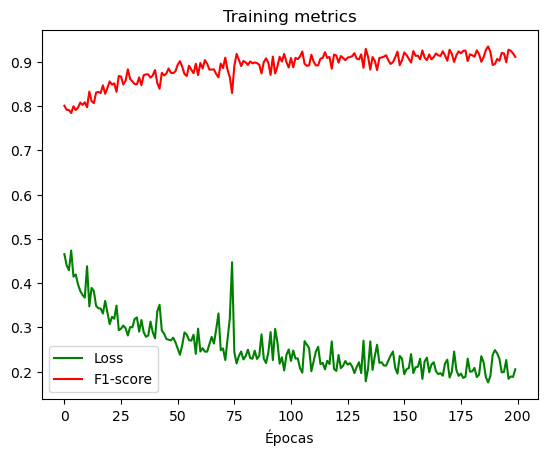

In [90]:
# Plot mean loss
x_axis = [i for i in range(200)]

splits=49
plt.plot(x_axis, [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)], 'g', label='Loss')
# plt.plot(x_axis, [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)], 'b', label='n')
plt.plot(x_axis, [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)], 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()

In [91]:
trainer.save_checkpoint("saves/resnet50_PlantVillage_focalloss_transfer.pt")

Now we can reload it w/o training:

In [92]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

inference_model = ResNetCustom.load_from_checkpoint("saves/resnet50_PlantVillage_focalloss_transfer.pt", map_location="cuda", gamma=0., class_sizes=[1,1])

In [93]:
from tqdm.autonotebook import tqdm

true_y, pred_y = [], []
for batch in tqdm(iter(dataloaders['val']), total=len(dataloaders['val'])):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())

  0%|          | 0/13 [00:00<?, ?it/s]

In [94]:
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.978     0.972     0.975       326
           1      0.892     0.914     0.902        81

    accuracy                          0.961       407
   macro avg      0.935     0.943     0.939       407
weighted avg      0.961     0.961     0.961       407



## ResNet50 + transfer learning + 5-Fold

## <span style="color:blue">Plant Village</span>

In [10]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = datasets.ImageFolder('../data/PlantVillage/train',data_transforms)

# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
class_0_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==1).flatten()
# class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(image_dataset, class_1_idxs)
class_0_subset = Subset(image_dataset, class_0_idxs)
image_dataset = ConcatDataset([class_0_subset, class_1_subset])

Class 0: 1591 / Class 1: 373 / BDeg:  4.265415549597855


In [11]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self, config, class_sizes):
        super().__init__()
        self.gamma = config['gamma']
        self.class_sizes = class_sizes
        self.lr = config['lr']
        self.n_classes = len(self.class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
#         self.fuzzyloss = FuzzyLoss(gamma=self.gamma, class_sizes=class_sizes).cuda()
        self.fuzzyloss = nn.CrossEntropyLoss().cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
#         mean_loss, losses = self.fuzzyloss(logits, y)
        mean_loss = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
#         self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
#             "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
#                                 optimizer ,max_lr=0.01,
#                                 steps_per_epoch=len(trainloader),
#                                 epochs=EPOCHS)
        }

In [17]:
K=5
BATCH_SIZE=10
EPOCHS=1
GAMMA_0=2

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

def train_tune(config):
    kfold = KFold(n_splits=K, shuffle=True)
    reports = []
    mean_f1s = []
    for fold,(train_idx,val_idx) in enumerate(kfold.split(image_dataset)):
        print(f'------------fold nº {fold}----------------------')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        trainloader = torch.utils.data.DataLoader(
                          image_dataset, 
                          batch_size=BATCH_SIZE, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
                          image_dataset,
                          batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Train this fold
#         model = ResNetCustom(gamma=GAMMA_0, class_sizes=[c0_s,c1_s])
        model = ResNetCustom(config, class_sizes=[c0_s,c1_s])
        trainer = pl.Trainer(max_epochs=config['epochs'], devices=1, accelerator="gpu")
        trainer.fit(model, trainloader)

        # Test this fold
        true_y, pred_y = [], []
        for batch in tqdm(iter(testloader), total=len(testloader)):
            x, y = batch
            true_y.extend(y)
            preds, probs = get_prediction(x, model)
            pred_y.extend(preds.cpu())

        report = classification_report(true_y, pred_y, output_dict=True)
        reports.append(report)
        mean_f1s.append((report['0']['f1-score']+report['1']['f1-score'])/2)
#         print('=> CONFIG:', config)
#         print(classification_report(true_y, pred_y))
    max_f1_idx = mean_f1s.index(max(mean_f1s))
    return reports[max_f1_idx]

EPOCHS = [10, 25, 35]
GAMMAS = [0, 0.5, 2]
LRS = [1e-5, 1e-4, 1e-3]

grid_search = pd.DataFrame(columns=['epochs','gamma','lr','f1-0','f1-1','acc'])

for epochs in EPOCHS:
    for gamma in GAMMAS:
        for lr in LRS:
            config = {'epochs': epochs, 'gamma': gamma, 'lr': lr}
            report = train_tune(config)
            grid_search = grid_search.append(
                            pd.Series(
                                [epochs,gamma,lr,report['0']['f1-score'],report['1']['f1-score'],report['accuracy']],
                                index=grid_search.columns), 
                            ignore_index=True)
            grid_search.to_csv('./grid_search/plant_village_baseline.csv')
grid_search

------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.331, v_num=6]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.331, v_num=6]



100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.319, v_num=7]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.319, v_num=7]


100%|██████████| 40/40 [00:42<00:00,  1.06s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.292, v_num=8]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.292, v_num=8]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.34, v_num=9] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.34, v_num=9]


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.36, v_num=10] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.36, v_num=10]


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0789, v_num=11]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0789, v_num=11]


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.0918, v_num=12]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0918, v_num=12]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.91it/s, loss=0.215, v_num=13] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.215, v_num=13]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.90it/s, loss=0.144, v_num=14] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.87it/s, loss=0.144, v_num=14]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.90it/s, loss=0.104, v_num=15] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.104, v_num=15]


100%|██████████| 40/40 [00:42<00:00,  1.06s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.90it/s, loss=0.0953, v_num=16]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.0953, v_num=16]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.90it/s, loss=0.0698, v_num=17]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0698, v_num=17]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.134, v_num=18] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.134, v_num=18]


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.0744, v_num=19]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0744, v_num=19]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.146, v_num=20] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.146, v_num=20]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.264, v_num=21]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.264, v_num=21]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.333, v_num=22]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.333, v_num=22]


100%|██████████| 40/40 [00:42<00:00,  1.06s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.90it/s, loss=0.337, v_num=23]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.87it/s, loss=0.337, v_num=23]


100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.305, v_num=24]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.305, v_num=24]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.307, v_num=25]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.307, v_num=25]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.107, v_num=26] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.107, v_num=26]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.141, v_num=27] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.141, v_num=27]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.119, v_num=28] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.119, v_num=28]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.0905, v_num=29]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0905, v_num=29]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.146, v_num=30] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.146, v_num=30]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.0245, v_num=31]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0245, v_num=31]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.272, v_num=32] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.272, v_num=32]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.0579, v_num=33]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0579, v_num=33]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.0427, v_num=34]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0427, v_num=34]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.175, v_num=35] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.175, v_num=35]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.369, v_num=36]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.369, v_num=36]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.26, v_num=37] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.26, v_num=37]


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.288, v_num=38]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.288, v_num=38]


100%|██████████| 40/40 [00:42<00:00,  1.06s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.279, v_num=39]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.279, v_num=39]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.311, v_num=40]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.311, v_num=40]


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.87it/s, loss=0.0689, v_num=41]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0689, v_num=41]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.085, v_num=42] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.085, v_num=42]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.23, v_num=43]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.23, v_num=43]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.102, v_num=44] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.102, v_num=44]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.0923, v_num=45]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0923, v_num=45]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.0486, v_num=46]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0486, v_num=46]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.0305, v_num=47]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0305, v_num=47]


100%|██████████| 40/40 [00:42<00:00,  1.07s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.054, v_num=48] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.054, v_num=48]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0522, v_num=49]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0522, v_num=49]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:57<00:00,  2.75it/s, loss=0.392, v_num=50]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:58<00:00,  2.72it/s, loss=0.392, v_num=50]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.197, v_num=51]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.197, v_num=51]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:54<00:00,  2.89it/s, loss=0.215, v_num=52]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.215, v_num=52]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.204, v_num=53]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.204, v_num=53]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.294, v_num=54]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.294, v_num=54]


100%|██████████| 40/40 [00:41<00:00,  1.05s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:54<00:00,  2.88it/s, loss=0.215, v_num=55]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.215, v_num=55]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.198, v_num=56] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.198, v_num=56]


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:54<00:00,  2.87it/s, loss=0.115, v_num=57] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.115, v_num=57]


100%|██████████| 40/40 [00:42<00:00,  1.07s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0564, v_num=58]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0564, v_num=58]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0857, v_num=59]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0857, v_num=59]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0991, v_num=60]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0991, v_num=60]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.0425, v_num=61] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0425, v_num=61]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:54<00:00,  2.87it/s, loss=0.00606, v_num=62]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.00606, v_num=62]


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.325, v_num=63]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.325, v_num=63]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0454, v_num=64] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0454, v_num=64]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0302, v_num=65] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0302, v_num=65]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.16, v_num=66] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.16, v_num=66]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.193, v_num=67]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.193, v_num=67]


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.173, v_num=68]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.173, v_num=68]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.277, v_num=69]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.277, v_num=69]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.2, v_num=70]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.2, v_num=70]


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0376, v_num=71]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0376, v_num=71]


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.248, v_num=72] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.248, v_num=72]


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0625, v_num=73]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.0625, v_num=73]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0775, v_num=74]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.0775, v_num=74]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.0527, v_num=75]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.0527, v_num=75]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.321, v_num=76]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.321, v_num=76]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.034, v_num=77]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.034, v_num=77]


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0864, v_num=78] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.0864, v_num=78]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.00515, v_num=79]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.00515, v_num=79]


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.0589, v_num=80] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.0589, v_num=80]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.203, v_num=81]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.203, v_num=81]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.184, v_num=82]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.81it/s, loss=0.184, v_num=82]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.217, v_num=83]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.217, v_num=83]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.192, v_num=84]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.192, v_num=84]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.201, v_num=85]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.81it/s, loss=0.201, v_num=85]


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0623, v_num=86]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.81it/s, loss=0.0623, v_num=86]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.0495, v_num=87]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.0495, v_num=87]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0487, v_num=88]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.81it/s, loss=0.0487, v_num=88]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0428, v_num=89]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.0428, v_num=89]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.0732, v_num=90]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.0732, v_num=90]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.0732, v_num=91] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.0732, v_num=91]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.355, v_num=92]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.79it/s, loss=0.355, v_num=92]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.82it/s, loss=0.041, v_num=93]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.041, v_num=93]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:55<00:00,  2.82it/s, loss=0.146, v_num=94]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.146, v_num=94]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 158/158 [00:56<00:00,  2.79it/s, loss=0.05, v_num=95]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.05, v_num=95]


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.81it/s, loss=0.141, v_num=96]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.141, v_num=96]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.181, v_num=97]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.181, v_num=97]


100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.81it/s, loss=0.185, v_num=98]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.185, v_num=98]


100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s, loss=0.13, v_num=99] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.13, v_num=99]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.161, v_num=100]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.161, v_num=100]


100%|██████████| 40/40 [00:45<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.281, v_num=101] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.281, v_num=101]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.052, v_num=102] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.052, v_num=102]


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s, loss=0.141, v_num=103] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.75it/s, loss=0.141, v_num=103]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.77it/s, loss=0.049, v_num=104] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.74it/s, loss=0.049, v_num=104]


100%|██████████| 40/40 [00:45<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.0656, v_num=105]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.74it/s, loss=0.0656, v_num=105]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.0561, v_num=106] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.74it/s, loss=0.0561, v_num=106]


100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.76it/s, loss=0.0534, v_num=107] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.73it/s, loss=0.0534, v_num=107]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.75it/s, loss=0.0203, v_num=108] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.73it/s, loss=0.0203, v_num=108]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:57<00:00,  2.74it/s, loss=0.0434, v_num=109] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.72it/s, loss=0.0434, v_num=109]


100%|██████████| 40/40 [00:47<00:00,  1.18s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.70it/s, loss=0.0601, v_num=110] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.68it/s, loss=0.0601, v_num=110]


100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s, loss=0.173, v_num=111]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.69it/s, loss=0.173, v_num=111]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s, loss=0.135, v_num=112]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.69it/s, loss=0.135, v_num=112]


100%|██████████| 40/40 [00:45<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.70it/s, loss=0.152, v_num=113]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.68it/s, loss=0.152, v_num=113]


100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:58<00:00,  2.70it/s, loss=0.129, v_num=114]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.68it/s, loss=0.129, v_num=114]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.67it/s, loss=0.151, v_num=115]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.65it/s, loss=0.151, v_num=115]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.67it/s, loss=0.0702, v_num=116]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.65it/s, loss=0.0702, v_num=116]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.65it/s, loss=0.0684, v_num=117]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.63it/s, loss=0.0684, v_num=117]


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.65it/s, loss=0.0409, v_num=118]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.62it/s, loss=0.0409, v_num=118]


100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.65it/s, loss=0.0677, v_num=119]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.62it/s, loss=0.0677, v_num=119]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [00:59<00:00,  2.64it/s, loss=0.0295, v_num=120]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.61it/s, loss=0.0295, v_num=120]


100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.63it/s, loss=0.0347, v_num=121] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.61it/s, loss=0.0347, v_num=121]


100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.59it/s, loss=0.103, v_num=122]  

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.57it/s, loss=0.103, v_num=122]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.61it/s, loss=0.0455, v_num=123]  

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.59it/s, loss=0.0455, v_num=123]


100%|██████████| 40/40 [00:47<00:00,  1.18s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.59it/s, loss=0.0109, v_num=124] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.57it/s, loss=0.0109, v_num=124]


100%|██████████| 40/40 [00:47<00:00,  1.19s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:00<00:00,  2.59it/s, loss=0.0193, v_num=125] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.57it/s, loss=0.0193, v_num=125]


100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.58it/s, loss=0.249, v_num=126]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.56it/s, loss=0.249, v_num=126]


100%|██████████| 40/40 [00:48<00:00,  1.21s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.58it/s, loss=0.158, v_num=127]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:01<00:00,  2.55it/s, loss=0.158, v_num=127]


100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.55it/s, loss=0.174, v_num=128]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.53it/s, loss=0.174, v_num=128]


100%|██████████| 40/40 [00:47<00:00,  1.19s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.53it/s, loss=0.258, v_num=129]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.51it/s, loss=0.258, v_num=129]


100%|██████████| 40/40 [00:47<00:00,  1.19s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.54it/s, loss=0.2, v_num=130]  

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.52it/s, loss=0.2, v_num=130]


100%|██████████| 40/40 [00:47<00:00,  1.20s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.52it/s, loss=0.0527, v_num=131]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:03<00:00,  2.50it/s, loss=0.0527, v_num=131]


100%|██████████| 40/40 [00:48<00:00,  1.21s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.53it/s, loss=0.0936, v_num=132]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:03<00:00,  2.51it/s, loss=0.0936, v_num=132]


100%|██████████| 40/40 [00:47<00:00,  1.20s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:02<00:00,  2.52it/s, loss=0.231, v_num=133] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:03<00:00,  2.50it/s, loss=0.231, v_num=133]


100%|██████████| 40/40 [00:47<00:00,  1.18s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:03<00:00,  2.48it/s, loss=0.0618, v_num=134]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.46it/s, loss=0.0618, v_num=134]


100%|██████████| 40/40 [00:47<00:00,  1.20s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.46it/s, loss=0.0523, v_num=135]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.44it/s, loss=0.0523, v_num=135]


100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:03<00:00,  2.47it/s, loss=0.0252, v_num=136] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=0.0252, v_num=136]


100%|██████████| 40/40 [00:48<00:00,  1.21s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.46it/s, loss=0.347, v_num=137]  

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.44it/s, loss=0.347, v_num=137]


100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.46it/s, loss=0.386, v_num=138]  

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.44it/s, loss=0.386, v_num=138]


100%|██████████| 40/40 [00:49<00:00,  1.23s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.43it/s, loss=0.0564, v_num=139] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:05<00:00,  2.41it/s, loss=0.0564, v_num=139]


100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 158/158 [01:04<00:00,  2.44it/s, loss=0.0428, v_num=140] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 158/158 [01:05<00:00,  2.42it/s, loss=0.0428, v_num=140]


100%|██████████| 40/40 [00:48<00:00,  1.20s/it]


,epochs,gamma,lr,f1-0,f1-1,acc
0,10.0,0.0,0.00001,0.943723,0.571429,0.900510
1,10.0,0.0,0.00010,0.996689,0.989011,0.994911
2,10.0,0.0,0.00100,0.998459,0.992701,0.997455
3,10.0,0.5,0.00001,0.939617,0.616822,0.895674
4,10.0,0.5,0.00010,0.996732,0.988372,0.994898
5,10.0,0.5,0.00100,1.000000,1.000000,1.000000
6,10.0,2.0,0.00001,0.958457,0.745455,0.928571
7,10.0,2.0,0.00010,0.996805,0.987500,0.994911
8,10.0,2.0,0.00100,1.000000,1.000000,1.000000
9,25.0,0.0,0.00001,0.986047,0.936170,0.977099


In [18]:
grid_search.to_csv('./grid_search/plant_village_baseline.csv')

In [39]:
mean_losses = []
mean_acc = []
mean_f1s = []

config = {'epochs': 10, 'gamma': 2, 'lr': 1e-3}
report = train_tune(config)
print(report)

------------fold nº 0----------------------


C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.87it/s, loss=0.252, v_num=146] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.252, v_num=146]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0461, v_num=147]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0461, v_num=147]


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.285, v_num=148] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.84it/s, loss=0.285, v_num=148]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.85it/s, loss=0.109, v_num=149] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.109, v_num=149]


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.86it/s, loss=0.0171, v_num=150] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 158/158 [00:55<00:00,  2.83it/s, loss=0.0171, v_num=150]


100%|██████████| 40/40 [00:43<00:00,  1.08s/it]

{'0': {'precision': 0.9968944099378882, 'recall': 0.9968944099378882, 'f1-score': 0.9968944099378882, 'support': 322}, '1': {'precision': 0.9857142857142858, 'recall': 0.9857142857142858, 'f1-score': 0.9857142857142858, 'support': 70}, 'accuracy': 0.9948979591836735, 'macro avg': {'precision': 0.991304347826087, 'recall': 0.991304347826087, 'f1-score': 0.991304347826087, 'support': 392}, 'weighted avg': {'precision': 0.9948979591836735, 'recall': 0.9948979591836735, 'f1-score': 0.9948979591836735, 'support': 392}}


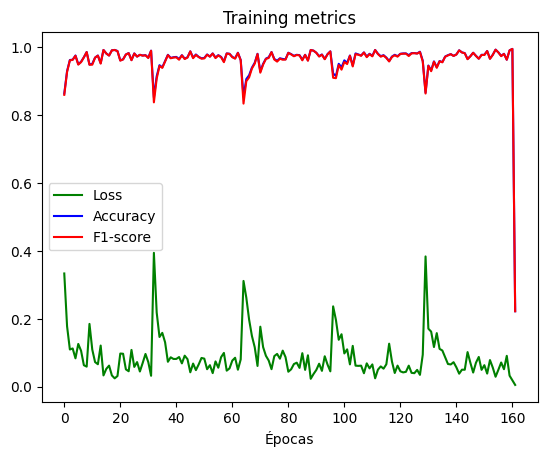

In [43]:
# Plot mean loss
ml = [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)]
ma = [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)]
mf = [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)]
x_axis = [i for i in range(162)]

splits=49
for i, l in enumerate(mean_losses):
    mean_losses[i] = l.cpu().detach()
plt.plot(x_axis, ml, 'g', label='Loss')
plt.plot(x_axis, ma, 'b', label='Accuracy')
plt.plot(x_axis, mf, 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()

## <span style="color:blue">UTKFace</span>

In [50]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = datasets.ImageFolder('../data/UTKFace/train',data_transforms)

# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
class_0_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==1).flatten()
class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(image_dataset, class_1_idxs)
class_0_subset = Subset(image_dataset, class_0_idxs)
image_dataset = ConcatDataset([class_0_subset, class_1_subset])

Class 0: 11317 / Class 1: 2589 / BDeg:  4.371185786017768


In [53]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self,
                 gamma=0.,
                 class_sizes=[1,1],
        ):
        super().__init__()
        self.gamma = config['gamma']
        self.class_sizes = class_sizes
        self.lr = config['lr']
        self.n_classes = len(self.class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
#         self.fuzzyloss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes).cuda()
        self.fuzzyloss = nn.CrossEntropyLoss().cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
#         mean_loss, losses = self.fuzzyloss(logits, y)
        mean_loss = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
#         self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
#             "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
#                                 optimizer ,max_lr=0.01,
#                                 steps_per_epoch=len(trainloader),
#                                 epochs=EPOCHS)
        }

In [54]:
K=5
BATCH_SIZE=10
EPOCHS=1
GAMMA_0=2

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

def train_tune(config):
    kfold = KFold(n_splits=K, shuffle=True)
    reports = []
    mean_f1s = []
    for fold,(train_idx,val_idx) in enumerate(kfold.split(image_dataset)):
        print(f'------------fold nº {fold}----------------------')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        trainloader = torch.utils.data.DataLoader(
                          image_dataset, 
                          batch_size=BATCH_SIZE, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
                          image_dataset,
                          batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Train this fold
#         model = ResNetCustom(gamma=GAMMA_0, class_sizes=[c0_s,c1_s])
        model = ResNetCustom(config, class_sizes=[c0_s,c1_s])
        trainer = pl.Trainer(max_epochs=config['epochs'], devices=1, accelerator="gpu")
        trainer.fit(model, trainloader)

        # Test this fold
        true_y, pred_y = [], []
        for batch in tqdm(iter(testloader), total=len(testloader)):
            x, y = batch
            true_y.extend(y)
            preds, probs = get_prediction(x, model)
            pred_y.extend(preds.cpu())

        report = classification_report(true_y, pred_y, output_dict=True)
        reports.append(report)
        mean_f1s.append((report['0']['f1-score']+report['1']['f1-score'])/2)
#         print('=> CONFIG:', config)
#         print(classification_report(true_y, pred_y))
    max_f1_idx = mean_f1s.index(max(mean_f1s))
    return reports[max_f1_idx]

EPOCHS = [10, 25, 35]
GAMMAS = [0]
LRS = [1e-3]

grid_search = pd.DataFrame(columns=['epochs','gamma','lr','f1-0','f1-1','acc'])

for epochs in EPOCHS:
    for gamma in GAMMAS:
        for lr in LRS:
            config = {'epochs': epochs, 'gamma': gamma, 'lr': lr}
            report = train_tune(config)
            grid_search = grid_search.append(
                            pd.Series(
                                [epochs,gamma,lr,report['0']['f1-score'],report['1']['f1-score'],report['accuracy']],
                                index=grid_search.columns), 
                            ignore_index=True)
            grid_search.to_csv('./grid_search/UTKFace_baseline.csv')
grid_search

------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 1113/1113 [06:42<00:00,  2.76it/s, loss=0.373, v_num=151]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:43<00:00,  2.76it/s, loss=0.373, v_num=151]


100%|██████████| 279/279 [05:19<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.366, v_num=152]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.366, v_num=152]


100%|██████████| 279/279 [05:21<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.396, v_num=153]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.396, v_num=153]


100%|██████████| 279/279 [05:17<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 9: 100%|██████████| 1113/1113 [06:39<00:00,  2.78it/s, loss=0.453, v_num=154]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.453, v_num=154]


100%|██████████| 279/279 [05:18<00:00,  1.14s/it]


------------fold nº 4----------------------


C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------

Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.316, v_num=155]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.316, v_num=155]


100%|██████████| 279/279 [05:08<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.405, v_num=156]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.405, v_num=156]


100%|██████████| 279/279 [05:16<00:00,  1.14s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:44<00:00,  2.75it/s, loss=0.409, v_num=157]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:44<00:00,  2.75it/s, loss=0.409, v_num=157]


100%|██████████| 279/279 [05:20<00:00,  1.15s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:45<00:00,  2.75it/s, loss=0.395, v_num=158]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:45<00:00,  2.74it/s, loss=0.395, v_num=158]


100%|██████████| 279/279 [05:23<00:00,  1.16s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:49<00:00,  2.72it/s, loss=0.481, v_num=159]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:49<00:00,  2.72it/s, loss=0.481, v_num=159]


100%|██████████| 279/279 [05:26<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:51<00:00,  2.71it/s, loss=0.365, v_num=160]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:51<00:00,  2.70it/s, loss=0.365, v_num=160]


100%|██████████| 279/279 [05:25<00:00,  1.17s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 1113/1113 [06:56<00:00,  2.67it/s, loss=0.352, v_num=161]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [06:57<00:00,  2.67it/s, loss=0.352, v_num=161]


100%|██████████| 279/279 [05:30<00:00,  1.19s/it]


------------fold nº 1----------------------


C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------

Epoch 34: 100%|██████████| 1113/1113 [07:06<00:00,  2.61it/s, loss=0.471, v_num=162]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [07:06<00:00,  2.61it/s, loss=0.471, v_num=162]


100%|██████████| 279/279 [05:35<00:00,  1.20s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 1113/1113 [07:19<00:00,  2.53it/s, loss=0.403, v_num=163]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [07:20<00:00,  2.53it/s, loss=0.403, v_num=163]


100%|██████████| 279/279 [05:38<00:00,  1.21s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 1113/1113 [07:33<00:00,  2.45it/s, loss=0.326, v_num=164]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [07:34<00:00,  2.45it/s, loss=0.326, v_num=164]


100%|██████████| 279/279 [05:38<00:00,  1.21s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 34: 100%|██████████| 1113/1113 [07:34<00:00,  2.45it/s, loss=0.392, v_num=165]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 1113/1113 [07:35<00:00,  2.44it/s, loss=0.392, v_num=165]


100%|██████████| 279/279 [05:45<00:00,  1.24s/it]


,epochs,gamma,lr,f1-0,f1-1,acc
0,10.0,0.0,0.001,0.905232,0.438356,0.837828
1,25.0,0.0,0.001,0.884323,0.522140,0.813736
2,35.0,0.0,0.001,0.894760,0.509165,0.826681


In [55]:
mean_losses = []
mean_acc = []
mean_f1s = []

config = {'epochs': 25, 'gamma': 0, 'lr': 1e-3}
report = train_tune(config)
print(report)

------------fold nº 0----------------------


C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------

Epoch 24: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.365, v_num=166]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.365, v_num=166]


100%|██████████| 279/279 [05:12<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.362, v_num=167]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:40<00:00,  2.78it/s, loss=0.362, v_num=167]


100%|██████████| 279/279 [05:11<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:41<00:00,  2.77it/s, loss=0.305, v_num=168]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:42<00:00,  2.77it/s, loss=0.305, v_num=168]


100%|██████████| 279/279 [05:12<00:00,  1.12s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:42<00:00,  2.76it/s, loss=0.342, v_num=169]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:43<00:00,  2.76it/s, loss=0.342, v_num=169]


100%|██████████| 279/279 [05:10<00:00,  1.11s/it]
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Score    | 0     
2 | model     | ResNet           | 23.5 M
3 | fuzzyloss | CrossEntropyLoss | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
C:\Users\laraquij\Anaconda3\envs\tfg_dani\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to

Epoch 24: 100%|██████████| 1113/1113 [06:45<00:00,  2.75it/s, loss=0.419, v_num=170]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1113/1113 [06:45<00:00,  2.74it/s, loss=0.419, v_num=170]


100%|██████████| 279/279 [05:15<00:00,  1.13s/it]


{'0': {'precision': 0.8777643747486932, 'recall': 0.9566170026292725, 'f1-score': 0.9154959110924721, 'support': 2282}, '1': {'precision': 0.6632653061224489, 'recall': 0.3907815631262525, 'f1-score': 0.4918032786885246, 'support': 499}, 'accuracy': 0.8550880978065444, 'macro avg': {'precision': 0.7705148404355711, 'recall': 0.6736992828777625, 'f1-score': 0.7036495948904984, 'support': 2781}, 'weighted avg': {'precision': 0.8392764081019849, 'recall': 0.8550880978065444, 'f1-score': 0.8394719543971935, 'support': 2781}}


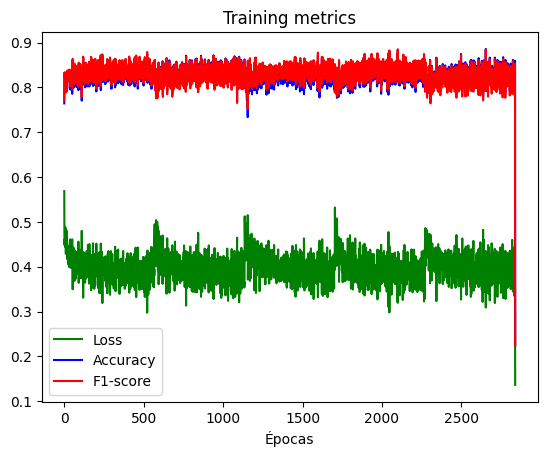

In [58]:
# Plot mean loss
ml = [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)]
ma = [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)]
mf = [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)]
x_axis = [i for i in range(2840)]

splits=49
for i, l in enumerate(mean_losses):
    mean_losses[i] = l.cpu().detach()
plt.plot(x_axis, ml, 'g', label='Loss')
plt.plot(x_axis, ma, 'b', label='Accuracy')
plt.plot(x_axis, mf, 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()

## <span style="color:blue">gender_clf</span>

In [3]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = datasets.ImageFolder('../data/gender_clf/train',data_transforms)

# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
class_0_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==1).flatten()
class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(image_dataset, class_1_idxs)
class_0_subset = Subset(image_dataset, class_0_idxs)
image_dataset = ConcatDataset([class_0_subset, class_1_subset])

Class 0: 23243 / Class 1: 4967 / BDeg:  4.679484598349104


In [4]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self,
                 gamma=0.,
                 class_sizes=[1,1],
        ):
        super().__init__()
        self.n_classes = len(class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
#         self.fuzzyloss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes).cuda()
        self.fuzzyloss = nn.CrossEntropyLoss().cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
#         mean_loss, losses = self.fuzzyloss(logits, y)
        mean_loss = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
#         self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=len(trainloader),
                                epochs=EPOCHS)
        }

In [5]:
EPOCHS=25
K=5
GAMMA_0=2
BATCH_SIZE=10

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

kfold = KFold(n_splits=K, shuffle=True)
for fold,(train_idx,val_idx) in enumerate(kfold.split(image_dataset)):
    print(f'------------fold nº {fold}----------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(
                      image_dataset, 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      image_dataset,
                      batch_size=BATCH_SIZE, sampler=val_subsampler)
    
    # Train this fold
    model = ResNetCustom(gamma=GAMMA_0, class_sizes=[c0_s,c1_s])
    trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu")
    trainer.fit(model, trainloader)
    
    # Test this fold
    true_y, pred_y = [], []
    for batch in tqdm(iter(testloader), total=len(testloader)):
        x, y = batch
        true_y.extend(y)
        preds, probs = get_prediction(x, model)
        pred_y.extend(preds.cpu())
    
    print(classification_report(true_y, pred_y, digits=3))

------------fold nº 0----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.875     0.987     0.927      4615
           1      0.860     0.365     0.513      1027

    accuracy                          0.874      5642
   macro avg      0.867     0.676     0.720      5642
weighted avg      0.872     0.874     0.852      5642

------------fold nº 1----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.902     0.971     0.935      4637
           1      0.794     0.513     0.624      1005

    accuracy                          0.890      5642
   macro avg      0.848     0.742     0.779      5642
weighted avg      0.883     0.890     0.880      5642

------------fold nº 2----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.938     0.906     0.922      4650
           1      0.620     0.718     0.665       992

    accuracy                          0.873      5642
   macro avg      0.779     0.812     0.793      5642
weighted avg      0.882     0.873     0.876      5642

------------fold nº 3----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.954     0.834     0.890      4678
           1      0.500     0.805     0.617       964

    accuracy                          0.829      5642
   macro avg      0.727     0.820     0.753      5642
weighted avg      0.876     0.829     0.843      5642

------------fold nº 4----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | BinaryAccuracy   | 0     
1 | f1score   | BinaryF1Scor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


  0%|          | 0/565 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.869     0.991     0.926      4663
           1      0.868     0.289     0.434       979

    accuracy                          0.869      5642
   macro avg      0.869     0.640     0.680      5642
weighted avg      0.869     0.869     0.841      5642



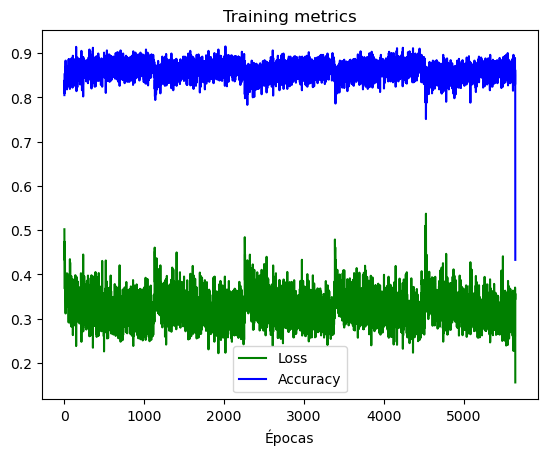

In [9]:
# Plot mean loss
x_axis = [i for i in range(5643)]

splits=50
plt.plot(x_axis, [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)], 'g', label='Loss')
plt.plot(x_axis, [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)], 'b', label='Accuracy')
# plt.plot(x_axis, [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)], 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()